### Acknowledgements
* Some code adapted from: https://www.tensorflow.org/tutorials/images/cnn
* Lots of notes adapted from Dr.Catia Silva's machine learning course

#### Note
* It is recommended to run this notebook on a server with lots of power and/or time, otherwise stick with all the models being trained on the "small_train" set

In [1]:
import tensorflow.keras as tk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
%matplotlib inline

### CIFAR-10

We will be using the CIFAR-10 dataset as an example for this notebook. Further details about it can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

CIFAR-10 has a bigger counterpart called CIFAR-100 which has 100 labeled classes instead of 10.

In [2]:
cifar10 = tk.datasets.cifar10

# I had to add the following code to solve some error involving an expired certificate
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

class_names = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

print(train_images.shape)
print(train_labels.shape)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

(50000, 32, 32, 3)
(50000, 1)


In [3]:
small_train_images = train_images[:40000]
small_train_labels = train_labels[:40000]
small_train_images.shape, small_train_labels.shape

((40000, 32, 32, 3), (40000, 1))

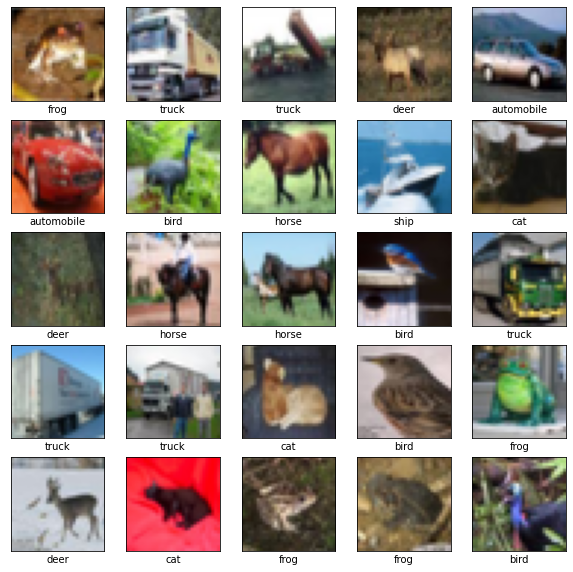

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
model = tk.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])
model.save_weights('randomWeights.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

2022-02-13 14:22:53.761012: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 14:22:56.663548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9640 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-02-13 14:22:56.665083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9640 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2022-02-13 14:22:56.666497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/r

# Early Stopping

Backpropagation cannot be shown to converge. We want it to stop at the global minimum. A necessary condition for this is $J(w^*)=0$.

**Criterion 1**: The Backpropagation algorithm is considered to have converged when the Euclidean norm of the gradient vector reaches a sufficiently small threshold
* learning may take a long time
* must compute the norm of the gradient vector

**Criterion 2**: The Backpropagation algorithm is considered to have converged when the absolute rate of change in the average squared error per epoch is sufficiently small.
* may result in premature termination of learning
* can test after each epoch for generalization ability, when it peaks, then stop

**Early Stopping** is similar to Criterion 2, it stops the training process if thhere is no improvement for the specifies value over thr cource of several epochs.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True) #Set patience lower when batchsize is big (steps per epoch > 30-5-)
epochs = 200

In [7]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(small_train_images, small_train_labels,
            batch_size=64,
            epochs=epochs,
            validation_data = (test_images, test_labels),
            callbacks=[early_stopping],
            verbose=1)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2022-02-13 14:22:58.596511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-02-13 14:22:59.593355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


625/625 [==============================] - 5s 3ms/step - loss: 1.7503 - accuracy: 0.3443 - val_loss: 1.4045 - val_accuracy: 0.4838
Epoch 2/200
625/625 [==============================] - 1s 2ms/step - loss: 1.3971 - accuracy: 0.4937 - val_loss: 1.2466 - val_accuracy: 0.5467
Epoch 3/200
625/625 [==============================] - 1s 2ms/step - loss: 1.2912 - accuracy: 0.5351 - val_loss: 1.1758 - val_accuracy: 0.5792
Epoch 4/200
625/625 [==============================] - 1s 2ms/step - loss: 1.2081 - accuracy: 0.5663 - val_loss: 1.1099 - val_accuracy: 0.6075
Epoch 5/200
625/625 [==============================] - 1s 2ms/step - loss: 1.1542 - accuracy: 0.5909 - val_loss: 1.0344 - val_accuracy: 0.6389
Epoch 6/200
625/625 [==============================] - 1s 2ms/step - loss: 1.1058 - accuracy: 0.6093 - val_loss: 1.0067 - val_accuracy: 0.6489
Epoch 7/200
625/625 [==============================] - 1s 2ms/step - loss: 1.0736 - accuracy: 0.6201 - val_loss: 0.9448 - val_accuracy: 0.6751
Epoch 8/200

# Online Vs. Batch Vs. mini Batch

Some vocab to understand before diving in:
* One **iteration** consists of a forward pass and a backward pass
* One **epoch** consists of a pass through all training samples

The number of samples used to perform a single training iteration (forward pass + backward pass) will impact the results.

* **Online Learning** (or stochastic/sequential learning): uses one sample to update the parameters of the network.
* **Batch Learning:** uses the entire training set to update the parameters of the network.

**Online Learning**

* Online learning performs local updates based on a single data sample

* Suppose we have $N$ training samples, then one epoch has $N$ parameter updates.

* It is good practice to randomly reorder the data points between each epoch. Yes! *Why?*

* Online mode of training requires less local storage for each synaptic connection

* Online mode of training makes the search in the weight space *stochastic* in nature

**Batch Learning**

* Batch learning performs *global* updates based on the entire training set

* One epoch in Batch learning, only has 1 iteration

* The errors in backward pass are the averaged error over all training samples

* Batch mode can ensure convergence to at least a local minimum

* Batch mode is easier to parallelize

* If a data set is has correlated features, online learning is more able to take advantage of this - unlike batch learning

**Mini-Batch Learning**

* We can consider mini-batch sets and perform updates based on each mini-batch.

* Similarly to online learning, it is common practice to create new random samples for each mini-batch set for each epoch. *Why?*

* Mini-batches need to be balanced for class representation

* Common sizes are 32, 64 and 128

In [8]:
epochNum = 400

In [9]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

online_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 1,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping],)

Epoch 1/200
40000/40000 [==============================] - 58s 1ms/step - loss: 1.7705 - accuracy: 0.3447 - val_loss: 1.5065 - val_accuracy: 0.4558
Epoch 2/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6516 - accuracy: 0.3964 - val_loss: 1.6327 - val_accuracy: 0.4227
Epoch 3/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6274 - accuracy: 0.4096 - val_loss: 1.4757 - val_accuracy: 0.4822
Epoch 4/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6261 - accuracy: 0.4160 - val_loss: 1.5807 - val_accuracy: 0.4261
Epoch 5/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6169 - accuracy: 0.4147 - val_loss: 1.4881 - val_accuracy: 0.4718
Epoch 6/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6162 - accuracy: 0.4176 - val_loss: 1.5533 - val_accuracy: 0.4323
Epoch 7/200
40000/40000 [==============================] - 57s 1ms/step - loss: 1.6305 - accuracy: 0.4156 - val_

In [10]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_32_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 32,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping],)

Epoch 1/200
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7069 - accuracy: 0.3650 - val_loss: 1.3982 - val_accuracy: 0.4868
Epoch 2/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.3845 - accuracy: 0.4963 - val_loss: 1.2685 - val_accuracy: 0.5444
Epoch 3/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.2673 - accuracy: 0.5463 - val_loss: 1.1402 - val_accuracy: 0.6002
Epoch 4/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.2072 - accuracy: 0.5659 - val_loss: 1.0804 - val_accuracy: 0.6157
Epoch 5/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.1513 - accuracy: 0.5876 - val_loss: 1.0219 - val_accuracy: 0.6437
Epoch 6/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.1108 - accuracy: 0.6050 - val_loss: 1.0149 - val_accuracy: 0.6452
Epoch 7/200
1250/1250 [==============================] - 2s 2ms/step - loss: 1.0809 - accuracy: 0.6151 - val_loss: 0.9576 - val_ac

In [11]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_64_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 64,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
625/625 [==============================] - 2s 3ms/step - loss: 1.7615 - accuracy: 0.3445 - val_loss: 1.4223 - val_accuracy: 0.4849
Epoch 2/200
625/625 [==============================] - 1s 2ms/step - loss: 1.4300 - accuracy: 0.4798 - val_loss: 1.2644 - val_accuracy: 0.5489
Epoch 3/200
625/625 [==============================] - 1s 2ms/step - loss: 1.3138 - accuracy: 0.5263 - val_loss: 1.1869 - val_accuracy: 0.5752
Epoch 4/200
625/625 [==============================] - 1s 2ms/step - loss: 1.2343 - accuracy: 0.5584 - val_loss: 1.1131 - val_accuracy: 0.6081
Epoch 5/200
625/625 [==============================] - 1s 2ms/step - loss: 1.1786 - accuracy: 0.5813 - val_loss: 1.0975 - val_accuracy: 0.6123
Epoch 6/200
625/625 [==============================] - 1s 2ms/step - loss: 1.1260 - accuracy: 0.6004 - val_loss: 1.0105 - val_accuracy: 0.6453
Epoch 7/200
625/625 [==============================] - 1s 2ms/step - loss: 1.0851 - accuracy: 0.6155 - val_loss: 0.9481 - val_accuracy: 0.6688

In [12]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_128_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 128,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
313/313 [==============================] - 2s 4ms/step - loss: 1.8091 - accuracy: 0.3178 - val_loss: 1.4572 - val_accuracy: 0.4608
Epoch 2/200
313/313 [==============================] - 1s 3ms/step - loss: 1.4716 - accuracy: 0.4636 - val_loss: 1.3122 - val_accuracy: 0.5377
Epoch 3/200
313/313 [==============================] - 1s 3ms/step - loss: 1.3480 - accuracy: 0.5101 - val_loss: 1.1867 - val_accuracy: 0.5828
Epoch 4/200
313/313 [==============================] - 1s 3ms/step - loss: 1.2631 - accuracy: 0.5475 - val_loss: 1.1866 - val_accuracy: 0.5810
Epoch 5/200
313/313 [==============================] - 1s 3ms/step - loss: 1.2082 - accuracy: 0.5681 - val_loss: 1.0676 - val_accuracy: 0.6218
Epoch 6/200
313/313 [==============================] - 1s 3ms/step - loss: 1.1516 - accuracy: 0.5877 - val_loss: 1.0395 - val_accuracy: 0.6341
Epoch 7/200
313/313 [==============================] - 1s 3ms/step - loss: 1.1126 - accuracy: 0.6035 - val_loss: 0.9940 - val_accuracy: 0.6514

In [13]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_256_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 256,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
157/157 [==============================] - 1s 7ms/step - loss: 1.9133 - accuracy: 0.2808 - val_loss: 1.5496 - val_accuracy: 0.4217
Epoch 2/200
157/157 [==============================] - 1s 4ms/step - loss: 1.5284 - accuracy: 0.4397 - val_loss: 1.4011 - val_accuracy: 0.4919
Epoch 3/200
157/157 [==============================] - 1s 4ms/step - loss: 1.4105 - accuracy: 0.4926 - val_loss: 1.2832 - val_accuracy: 0.5454
Epoch 4/200
157/157 [==============================] - 1s 4ms/step - loss: 1.3310 - accuracy: 0.5211 - val_loss: 1.2153 - val_accuracy: 0.5682
Epoch 5/200
157/157 [==============================] - 1s 5ms/step - loss: 1.2734 - accuracy: 0.5428 - val_loss: 1.1464 - val_accuracy: 0.5914
Epoch 6/200
157/157 [==============================] - 1s 5ms/step - loss: 1.2262 - accuracy: 0.5606 - val_loss: 1.1086 - val_accuracy: 0.6091
Epoch 7/200
157/157 [==============================] - 1s 5ms/step - loss: 1.1800 - accuracy: 0.5798 - val_loss: 1.0545 - val_accuracy: 0.6328

In [29]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_512_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 512,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
79/79 [==============================] - 1s 13ms/step - loss: 2.0717 - accuracy: 0.2156 - val_loss: 1.7436 - val_accuracy: 0.3472
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 1.6625 - accuracy: 0.3850 - val_loss: 1.5162 - val_accuracy: 0.4403
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 1.5177 - accuracy: 0.4454 - val_loss: 1.4916 - val_accuracy: 0.4724
Epoch 4/200
79/79 [==============================] - 1s 7ms/step - loss: 1.4385 - accuracy: 0.4790 - val_loss: 1.3247 - val_accuracy: 0.5248
Epoch 5/200
79/79 [==============================] - 1s 7ms/step - loss: 1.3786 - accuracy: 0.5044 - val_loss: 1.2890 - val_accuracy: 0.5384
Epoch 6/200
79/79 [==============================] - 1s 7ms/step - loss: 1.3349 - accuracy: 0.5201 - val_loss: 1.2407 - val_accuracy: 0.5624
Epoch 7/200
79/79 [==============================] - 1s 7ms/step - loss: 1.2861 - accuracy: 0.5383 - val_loss: 1.1733 - val_accuracy: 0.5846
Epoch 8/200


In [30]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_1024_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 1024,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
40/40 [==============================] - 1s 25ms/step - loss: 2.1875 - accuracy: 0.1717 - val_loss: 1.9100 - val_accuracy: 0.2967
Epoch 2/200
40/40 [==============================] - 1s 14ms/step - loss: 1.8018 - accuracy: 0.3297 - val_loss: 1.6571 - val_accuracy: 0.3919
Epoch 3/200
40/40 [==============================] - 1s 13ms/step - loss: 1.6228 - accuracy: 0.4013 - val_loss: 1.5623 - val_accuracy: 0.4360
Epoch 4/200
40/40 [==============================] - 1s 14ms/step - loss: 1.5364 - accuracy: 0.4354 - val_loss: 1.6253 - val_accuracy: 0.4244
Epoch 5/200
40/40 [==============================] - 1s 14ms/step - loss: 1.4983 - accuracy: 0.4555 - val_loss: 1.4038 - val_accuracy: 0.4994
Epoch 6/200
40/40 [==============================] - 1s 14ms/step - loss: 1.4317 - accuracy: 0.4797 - val_loss: 1.3562 - val_accuracy: 0.5174
Epoch 7/200
40/40 [==============================] - 1s 13ms/step - loss: 1.4014 - accuracy: 0.4929 - val_loss: 1.3247 - val_accuracy: 0.5259
Epoch 

In [31]:
model.load_weights('randomWeights.h5')
model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

mini_b_2048_history = model.fit(small_train_images, small_train_labels, epochs=200, batch_size = 2048,
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200
20/20 [==============================] - 2s 59ms/step - loss: 2.2659 - accuracy: 0.1345 - val_loss: 2.0945 - val_accuracy: 0.2301
Epoch 2/200
20/20 [==============================] - 1s 25ms/step - loss: 1.9648 - accuracy: 0.2632 - val_loss: 1.7608 - val_accuracy: 0.3588
Epoch 3/200
20/20 [==============================] - 1s 25ms/step - loss: 1.7646 - accuracy: 0.3464 - val_loss: 1.6425 - val_accuracy: 0.4016
Epoch 4/200
20/20 [==============================] - 1s 25ms/step - loss: 1.6596 - accuracy: 0.3873 - val_loss: 1.5597 - val_accuracy: 0.4309
Epoch 5/200
20/20 [==============================] - 1s 26ms/step - loss: 1.5806 - accuracy: 0.4198 - val_loss: 1.4810 - val_accuracy: 0.4588
Epoch 6/200
20/20 [==============================] - 1s 25ms/step - loss: 1.5201 - accuracy: 0.4428 - val_loss: 1.4468 - val_accuracy: 0.4783
Epoch 7/200
20/20 [==============================] - 1s 25ms/step - loss: 1.4790 - accuracy: 0.4620 - val_loss: 1.3843 - val_accuracy: 0.5030
Epoch 

In [36]:
## can only run this if the training set size is reduced, this shows another reason why batch learning is impractical. It requires a huge amount of data to be loaded into memory
# model.load_weights('randomWeights.h5')
# model.compile(optimizer='adam',
#               loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# batch_history = model.fit(small_train_images, small_train_labels, epochs=200, steps_per_epoch=1,
#                     validation_data=(test_images, test_labels), callbacks=[early_stopping],)

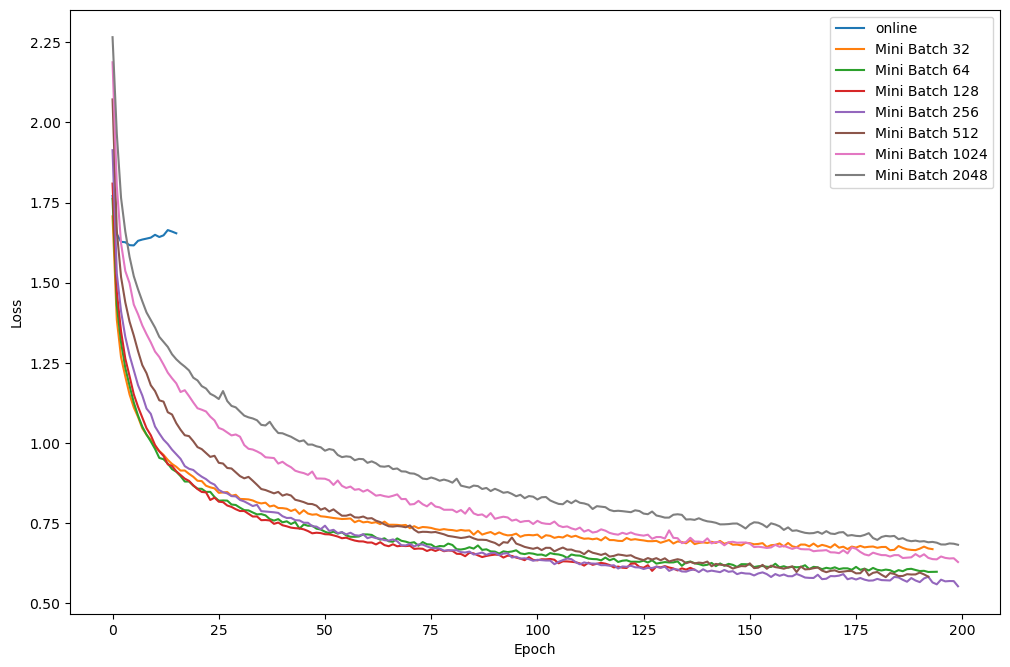

In [32]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(online_history.history['loss'], label='online')
plt.plot(mini_b_32_history.history['loss'], label='Mini Batch 32')
plt.plot(mini_b_64_history.history['loss'], label='Mini Batch 64')
plt.plot(mini_b_128_history.history['loss'], label='Mini Batch 128')
plt.plot(mini_b_256_history.history['loss'], label='Mini Batch 256')
plt.plot(mini_b_512_history.history['loss'], label='Mini Batch 512')
plt.plot(mini_b_1024_history.history['loss'], label='Mini Batch 1024')
plt.plot(mini_b_2048_history.history['loss'], label='Mini Batch 2048')

# plt.plot(batch_history.history['loss'], label='Batch') # Normally batch learning takes up too many resources to run

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

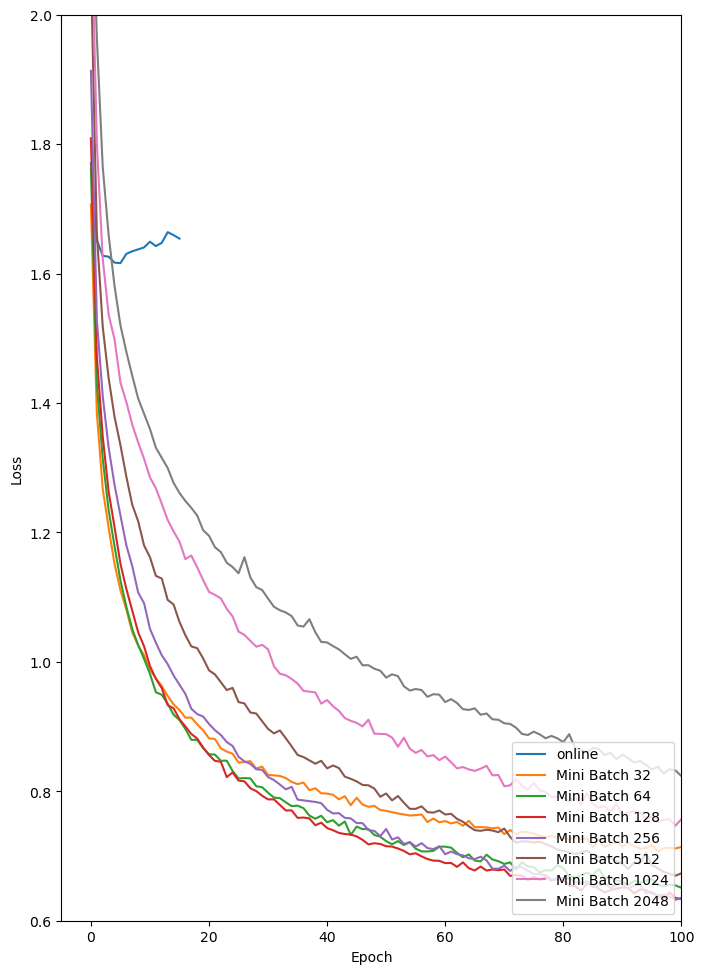

In [33]:
fig=plt.figure(figsize=(8, 12), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(online_history.history['loss'], label='online')
plt.plot(mini_b_32_history.history['loss'], label='Mini Batch 32')
plt.plot(mini_b_64_history.history['loss'], label='Mini Batch 64')
plt.plot(mini_b_128_history.history['loss'], label='Mini Batch 128')
plt.plot(mini_b_256_history.history['loss'], label='Mini Batch 256')
plt.plot(mini_b_512_history.history['loss'], label='Mini Batch 512')
plt.plot(mini_b_1024_history.history['loss'], label='Mini Batch 1024')
plt.plot(mini_b_2048_history.history['loss'], label='Mini Batch 2048')
plt.xlim(-5, 100)
plt.ylim(.6, 2)
# plt.plot(batch_history.history['loss'], label='Batch') # Normally batch learning takes up too many resources to run

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

# Activation Functions

MLPs may learn better with activation functions that are antisymmetric $\phi(-v) = -\phi(v)$ (e.g. hyperbolic tangent function) rather than non-symmetric (e.g. sigmoid function)
* If the activation function is non-symmetric, the output of each neuron is restricted to the interval $[0,1]$. Such a choice introduces a source of systematic bias for those neurons located beyond the first layer of the network.
* With an antisymmetric activation function, the output of each neuron is permitted to assume both positive and negative values in the interval $[-1,1]$, in which case it is likely for its mean to be zero.
* If the network connectivity is large, backpropagation learning with anti-symmetric activation functions can yield faster convergence than a similar process with non-symmetric, for which there is also empirical evidence.

# Dropout

A dropout layer is added to neural networks as a form of regularization. It randomly cuts some of the connections between the layers before and after itself with a set probability. This is helpful as it encourages the model to be more adapatable and not rely too much on any one connection/weight. 

In [16]:
dropout_model = tk.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tk.layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tk.layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)         

In [17]:
dropout_model.compile(optimizer='adam',
              loss=tk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = dropout_model.fit(small_train_images, small_train_labels,
            batch_size=64,
            epochs=epochs,
            validation_data = (test_images, test_labels),
            steps_per_epoch=steps_per_epoch,
            callbacks=[early_stopping],
            verbose=1)

test_loss, test_acc = dropout_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

NameError: name 'steps_per_epoch' is not defined